In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
stroke_processed = pd.read_csv('processed_df.csv') # this is the processed DF (from Todd's .ipnb) saved to a csv file

In [3]:
stroke = stroke_processed.copy()
display(stroke.head())

non_indep_vars = [
    'stroke',  # this is the target
    'smoking_status_formerly smoked', # we've decided to drop smoking_status column
    'smoking_status_never smoked',
    'smoking_status_smokes'
]

indep_vars = stroke.drop(columns = non_indep_vars) # features
dep_var = stroke.stroke   # target

print('Features: ', list(indep_vars.columns))
print('Target:',  dep_var.name)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,61.0,0,0,1,0,202.21,28.1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1,80.0,0,1,1,0,105.92,32.5,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0,49.0,0,0,1,1,171.23,34.4,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0,79.0,1,0,1,0,174.12,24.0,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Features:  ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children']
Target: stroke


#### Prepare undersample data

In [4]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state = 41)
X_und, y_und = undersampler.fit_resample(indep_vars, dep_var)
print(X_und.shape)
print(y_und.shape)

# split and scale data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.3, random_state=41)

print('Train data stroke count')
display(y_train.value_counts())
print('Test data stroke count')
display(y_test.value_counts())

(498, 12)
(498,)
Train data stroke count


0    175
1    173
Name: stroke, dtype: int64

Test data stroke count


1    76
0    74
Name: stroke, dtype: int64

#### Logistic Regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

feature_names = X_train.columns

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pl_clf = Pipeline([
    ( 'classifier', LogisticRegression() )
])

# GridSearchCV
hyperparams = { 
    'classifier__C': np.linspace(0.0001, 0.01, 50),
    'classifier__max_iter': range(80, 111)
}

gridsearch = GridSearchCV(pl_clf,  hyperparams, n_jobs = -1)

# train model
_ = gridsearch.fit(X_train, y_train)

In [6]:
# predict
y_pred = gridsearch.predict(X_test)

# best co-efficient
print(gridsearch.best_score_)
print(gridsearch.best_params_)

0.7501449275362319
{'classifier__C': 0.002726530612244898, 'classifier__max_iter': 80}


In [7]:
# Evaluation metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(tn, fp, fn, tp)
print([tp,fp])
print([fn,tn])

              precision    recall  f1-score   support

           0       0.73      0.69      0.71        74
           1       0.71      0.75      0.73        76

    accuracy                           0.72       150
   macro avg       0.72      0.72      0.72       150
weighted avg       0.72      0.72      0.72       150

51 23 19 57
[57, 23]
[19, 51]


#### ============================
One way for insurance company to increase revenue is to reduce the number of claims, which in turn relates to the health of policy holders.
Can insurance company offer incentives to policy holders to improve their health (hence reduce clains)?

If so, which health indicator should be used?

Can improvement in a single health indicator reduce the chance of having a stroke?

Question 1: Which indicator. 

We can choose the feature with highest weight learned by ML algo.

Question 2: Can improvement in a single indicator reduce the chance of having a stroke?

We can try using the test data, improve the indicator (say, lower glucose level) and see if number of people with stroke decreases.
#### ============================

In [9]:
gridsearch.best_estimator_.named_steps['classifier'].coef_

array([[-0.00326018,  0.21090733,  0.03600632,  0.06492108,  0.05360717,
        -0.01858163,  0.05407521,  0.00580389,  0.        , -0.00784451,
         0.03112709, -0.05485583]])

In [10]:
# feature and weight
coefs = gridsearch.best_estimator_.named_steps['classifier'].coef_
features = feature_names
print(features)
print(coefs)
pd.DataFrame(data = {
    'feature': features,
    'weight': coefs[0]
} ).sort_values(by='weight', ascending = False)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children'],
      dtype='object')
[[-0.00326018  0.21090733  0.03600632  0.06492108  0.05360717 -0.01858163
   0.05407521  0.00580389  0.         -0.00784451  0.03112709 -0.05485583]]


,feature,weight
1,age,0.210907
3,heart_disease,0.064921
6,avg_glucose_level,0.054075
4,ever_married,0.053607
2,hypertension,0.036006
10,work_type_Self-employed,0.031127
7,bmi,0.005804
8,work_type_Never_worked,0.000000
0,gender,-0.003260
9,work_type_Private,-0.007845


### Pick avg_glucose_level
### avg_glucose_level (unit: milligrams per decilitre) < 126 mg/dL  should be normal, normally 70-99mg/dL for non diabetic person)

In [11]:
stroke = stroke_processed.copy()
non_indep_vars = [
    'smoking_status_formerly smoked', # we've decided to drop smoking_status column
    'smoking_status_never smoked',
    'smoking_status_smokes'
]

stroke = stroke.drop(columns = non_indep_vars) # features

# people with high avg_glucose_level and have stroke
stroke_pos = stroke[(stroke.stroke == 1) & (stroke.avg_glucose_level > 126)]

display(stroke_pos.shape)
display(stroke_pos.head())

(100, 13)

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,1,0.0,1.0,0.0,0.0
1,0,61.0,0,0,1,0,202.21,28.1,1,0.0,0.0,1.0,0.0
3,0,49.0,0,0,1,1,171.23,34.4,1,0.0,1.0,0.0,0.0
4,0,79.0,1,0,1,0,174.12,24.0,1,0.0,0.0,1.0,0.0
5,1,81.0,0,0,1,1,186.21,29.0,1,0.0,1.0,0.0,0.0


In [12]:
# predict using original data
X_stroke_pos_test = stroke_pos.drop(columns = 'stroke')
y_stroke_pos_test = stroke.stroke

X_stroke_pos_test_scaled = scaler.transform(X_stroke_pos_test)
y_stroke_pos_pred = gridsearch.predict(X_stroke_pos_test_scaled)

pd.Series(y_stroke_pos_pred).value_counts()[1]

97

<AxesSubplot:xlabel='Avg glucose', ylabel='People with stroke'>

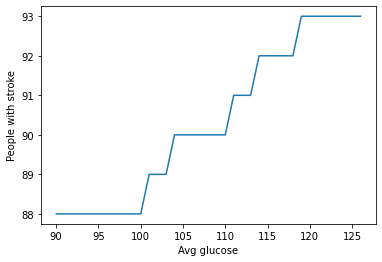

In [13]:
g_levels = []
stroke_cnts = []
for gl in range(126, 89, -1):
    X_stroke_pos_test2 = X_stroke_pos_test.copy()
    X_stroke_pos_test2.avg_glucose_level = gl

    X_stroke_pos_test2_scaled = scaler.transform(X_stroke_pos_test2)
    y_stroke_pos_pred2 = gridsearch.predict(X_stroke_pos_test2_scaled)

    n_strokes = pd.Series(y_stroke_pos_pred2).value_counts()[1]
    g_levels.append(gl)
    stroke_cnts.append(n_strokes)

df = pd.DataFrame( data = {
    'Avg glucose': g_levels,
    'People with stroke': stroke_cnts
})

sns.lineplot(data = df, x = 'Avg glucose', y = 'People with stroke')

#### According to the ML model, improvement of a single indicator (avg_glucose_level)
#### can reduce the chance of getting a stroke